<a href="https://colab.research.google.com/github/samsledje/Deep_PPI/blob/master/PPI_Intro2DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gzip as gz
from tqdm import tqdm

TensorFlow 2.x selected.


# Data

This data comes from the [STRING](https://string-db.org/) protein interaction database. We download only human protein-protein interactions, although with enough storage, memory, and time we could train on all interactions in the database. 

In [0]:
!wget https://stringdb-static.org/download/protein.links.detailed.v11.0/9606.protein.links.detailed.v11.0.txt.gz
!wget https://stringdb-static.org/download/protein.sequences.v11.0/9606.protein.sequences.v11.0.fa.gz
!wget https://stringdb-static.org/download/protein.info.v11.0/9606.protein.info.v11.0.txt.gz

--2020-01-30 14:18:25--  https://stringdb-static.org/download/protein.links.detailed.v11.0/9606.protein.links.detailed.v11.0.txt.gz
Resolving stringdb-static.org (stringdb-static.org)... 104.26.10.133, 104.26.11.133, 2606:4700:20::681a:a85, ...
Connecting to stringdb-static.org (stringdb-static.org)|104.26.10.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110085813 (105M) [application/x-gzip]
Saving to: ‘9606.protein.links.detailed.v11.0.txt.gz’

9606.protein.links. 100%[===================>] 104.99M  18.4MB/s    in 6.4s    

2020-01-30 14:18:31 (16.4 MB/s) - ‘9606.protein.links.detailed.v11.0.txt.gz’ saved [110085813/110085813]

--2020-01-30 14:18:32--  https://stringdb-static.org/download/protein.sequences.v11.0/9606.protein.sequences.v11.0.fa.gz
Resolving stringdb-static.org (stringdb-static.org)... 104.26.10.133, 104.26.11.133, 2606:4700:20::681a:a85, ...
Connecting to stringdb-static.org (stringdb-static.org)|104.26.10.133|:443... connected.
HTTP req

In [5]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_HOME = "/content/drive/My Drive/PhD/PPI_DL"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mv 9606.protein.links.detailed.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 9606.protein.sequences.v11.0.fa.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 9606.protein.info.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL

In [0]:
LINKS_FILE = f"{DRIVE_HOME}/9606.protein.links.detailed.v11.0.txt.gz"
SEQ_FILE = f"{DRIVE_HOME}/9606.protein.sequences.v11.0.fa.gz"
INFO_FILE = f"{DRIVE_HOME}/9606.protein.info.v11.0.txt.gz"

In [0]:
def read_fasta(fasta_file,comment="#"):
     with gz.open(fasta_file,"r") as f:
         names = []
         sequences = []
         name = None
         sequence = []
         for line in f:
             line = line.decode('utf-8')
             if line.startswith(comment):
                 continue
             line = line.strip()
             if line.startswith('>'):
                 if name is not None:
                     names.append(name)
                     sequences.append(''.join(sequence))
                 name = line[1:]
                 sequence = []
             else:
                 sequence.append(line.upper())
         if name is not None:
             names.append(name)
             sequences.append(''.join(sequence))
 
         return list(zip(names, sequences))

def encode_AC(sequence):
  alphabet = "ACDEFGHIKLMNPQRSTVWY"
  chem_props = np.array([0.62, -0.5,0.007187,8.1,0.046,1.181,27.5,0.29,-1,-0.03661,5.5,0.128,1.461,44.6,-0.9,3,-0.02382,13,0.105,1.587,40,-0.74,3,0.006802,12.3,0.151,1.862,62,1.19,-2.5,0.037552,5.2,0.29,2.228,115.5,0.48,0,0.179052,9,0,0.881,0,-0.4,-0.5,-0.01069,10.4,0.23,2.025,79,1.38,-1.8,0.021631,5.2,0.186,1.81,93.5,-1.5,3,0.017708,11.3,0.219,2.258,100,1.06,-1.8,0.051672,4.9,0.186,1.931,93.5,0.64,-1.3,0.002683,5.7,0.221,2.034,94.1,-0.78,2,0.005392,11.6,0.134,1.655,58.7,0.12,0,0.239531,8,0.131,1.468,41.9,-0.85,0.2,0.049211,10.5,0.18,1.932,80.7,-2.53,3,0.043587,10.5,0.291,2.56,105,-0.18,0.3,0.004627,9.2,0.062,1.298,29.3,-0.05,-0.4,0.003352,8.6,0.108,1.525,51.3,1.08,-1.5,0.057004,5.9,0.14,1.645,71.5,0.81,-3.4,0.037977,5.4,0.409,2.663,145.5,0.26,-2.3,117.3,6.2,0.298,2.368,0.023599])
  chem_props = chem_props.reshape(len(alphabet),7)

  return np.array([chem_props[alphabet.index(c.upper())] for c in sequence])

def encode_CT(sequence):
  encoding = {
      "A": 1,
      "G": 1,
      "V": 1,
      "I": 2,
      "L": 2,
      "F": 2,
      "P": 2,
      "Y": 3,
      "M": 3,
      "T": 3,
      "S": 3,
      "H": 4,
      "N": 4,
      "Q": 4,
      "W": 4,
      "R": 5,
      "K": 5,
      "O": 5,
      "D": 6,
      "U": 6,
      "E": 6,
      "C": 7,
      "X": 8,
      "B": 8,
      "Z": 8
  }
  nums = np.array([encoding[c.upper()] for c in sequence])
  return nums


# Compact Encoding of Proteins using Autoencoder LSTM

In [0]:
links = pd.read_csv(LINKS_FILE,sep=" ",compression="gzip")
info = pd.read_csv(INFO_FILE,sep="\t",compression="gzip")
seqs = pd.DataFrame(read_fasta(SEQ_FILE),columns=['protein_external_id','sequence'])
proteins = proteins.set_index('protein_external_id')
proteins = pd.merge(info,seqs,on='protein_external_id')



In [0]:
TRAINING_SIZE = 1000

prots_training = proteins.iloc[:TRAINING_SIZE,:]
seqs_training = prots_training['sequence']

In [0]:
seqs_CT = tf.keras.preprocessing.sequence.pad_sequences([encode_CT(s) for s in seqs_training])

In [0]:
X_train = seqs_CT.reshape((seqs_CT.shape[0], seqs_CT.shape[1], 1))

In [0]:
def build_autoencoders(input_size, input_features, encoded_size):

  input_seq = tf.keras.layers.Input(shape=(input_size,input_features))
  encoded = tf.keras.Sequential([
          tf.keras.layers.LSTM(encoded_size*2, activation='relu', input_shape=(input_size,input_features,)),
          tf.keras.layers.Dense(encoded_size)
  ])(input_seq)                  
                                 
  decoded = tf.keras.Sequential([
          tf.keras.layers.RepeatVector(input_size),
          tf.keras.layers.Dense(encoded_size*2),
          tf.keras.layers.LSTM(encoded_size, activation="relu", return_sequences=True),
          tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_features))
  ])(encoded)

  autoencoder = tf.keras.Model(input_seq,decoded)
  encoder = tf.keras.Model(input_seq,encoded)

  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  encoder.compile(optimizer='adam', loss='binary_crossentropy')

  return autoencoder, encoder

In [0]:
autoencoder, encoder = build_autoencoders(X_train.shape[1], X_train.shape[2], 128)

In [0]:
EPOCHS = 5
BATCH_SIZE = 32

autoencoder.fit(X_train, X_train,epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 289s 289ms/sample - loss: 6.7781
Epoch 2/5
1000/1000 [==============================] - 288s 288ms/sample - loss: 6.7781
Epoch 3/5
1000/1000 [==============================] - 286s 286ms/sample - loss: 6.7781
Epoch 4/5
1000/1000 [==============================] - 287s 287ms/sample - loss: 6.7781
Epoch 5/5
1000/1000 [==============================] - 283s 283ms/sample - loss: 6.7781


In [0]:
encoder.save(f"{DRIVE_HOME}/encoder.h5")
autoencoder.save(f"{DRIVE_HOME}/autoencoder.h5")

# PPI Prediction from Encoded Proteins

Now that we have trained an encoder that can produce low-dimensional representations of proteins, we can use these low-dimensional representations for the prediction task.

Given two proteins, we will first encode each protein into a length 128 vector. We can then create an "image" for the protein interaction by taking the outer product of the two vectors. This allows us to represent not only local but distant interactions that may occur after protein folding.

In [0]:
encoder = tf.keras.models.load_model(f"{DRIVE_HOME}/encoder.h5")

In [0]:
links[['protein1','protein2']]

,protein1,protein2
0,9606.ENSP00000000233,9606.ENSP00000272298
1,9606.ENSP00000000233,9606.ENSP00000253401
2,9606.ENSP00000000233,9606.ENSP00000401445
3,9606.ENSP00000000233,9606.ENSP00000418915
4,9606.ENSP00000000233,9606.ENSP00000327801
...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488
11759450,9606.ENSP00000485678,9606.ENSP00000342448
11759451,9606.ENSP00000485678,9606.ENSP00000350222
11759452,9606.ENSP00000485678,9606.ENSP00000367590


In [0]:
positive_interactions = pd.DataFrame({
    "p1": links["protein1"],
    "p2": links["protein2"],
    "interaction": [1] * len(links)
})

N_POSITIVE = 2000
positive_interactions = positive_interactions.iloc[:N_POSITIVE,:]

N_NEGATIVE = 13000

neg_p1 = np.random.choice(proteins.index, N_NEGATIVE)
neg_p2 = np.random.choice(proteins.index, N_NEGATIVE)

negative_interactions = pd.DataFrame({
    "p1": neg_p1,
    "p2": neg_p2,
    "interaction": [0] * N_NEGATIVE
})

interaction_dataset = pd.concat((positive_interactions, negative_interactions),axis=0)

In [0]:
interaction_dataset = interaction_dataset.merge(proteins,left_on='p1',right_on='protein_external_id')
interaction_dataset = interaction_dataset.drop(['preferred_name','protein_size','annotation'],axis=1)
interaction_dataset = interaction_dataset.rename(columns={"sequence":"s1"})
interaction_dataset = interaction_dataset.merge(proteins,left_on='p2',right_on='protein_external_id')
interaction_dataset = interaction_dataset.drop(['preferred_name','protein_size','annotation'],axis=1)
interaction_dataset = interaction_dataset.rename(columns={"sequence":"s2"})


In [0]:
interaction_dataset

,p1,p2,interaction,s1,s2
0,9606.ENSP00000000233,9606.ENSP00000272298,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
1,9606.ENSP00000359778,9606.ENSP00000272298,0,MKRLPLLVVFSTLLNCSYTQNCTKTPCLPNAKCEIRNGIEACYCNM...,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
2,9606.ENSP00000000233,9606.ENSP00000253401,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MTLLITGDSIVSAEAVWDHVTMANRELAFKAGDVIKVLDASNKDWW...
3,9606.ENSP00000000233,9606.ENSP00000401445,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVS...
4,9606.ENSP00000315137,9606.ENSP00000401445,0,MAELLRSLQDSQLVARFQRRCGLFPAPDEGPRENGADPTERAARVP...,MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVS...
...,...,...,...,...,...
14995,9606.ENSP00000310520,9606.ENSP00000282928,0,MESGQPARRIAMAPLLEYERQLVLELLDTDGLVVCARGLGADRLLY...,MLLDAGPQYPAIGVTTFGASRHHSAGDVAERDVGLGINPFADGMGA...
14996,9606.ENSP00000338487,9606.ENSP00000359378,0,MSRVAGTRTDVNELLQRWTPRCVRWHTGGARRVALDRPLVTACLPP...,MAVFLEAKDAHSVLKRFPRANEFLEELRQGTIERECMEEICSYEEV...
14997,9606.ENSP00000442786,9606.ENSP00000368682,0,MLSVQPDTKPKGCAGCNRKIKDRYLLKALDKYWHEDCLKCACCDCR...,MEAETGSSVETGKKANRGTRIALVVFVGGTLVLGTILFLVSQGLLS...
14998,9606.ENSP00000361400,9606.ENSP00000355013,0,MWLCPLALTLILMAASGAACEVKDVCVGSPGIPGTPGSHGLPGRDG...,MSRGSIEIPLRDTDEVIELDFDQLPEGDEVISILKQEHTQLHIWIA...


In [0]:
ct1 = np.array([encode_CT(seq) for seq in interaction_dataset['s1']])
ct2 = np.array([encode_CT(seq) for seq in interaction_dataset['s2']])

PADDING_LENGTH = 3530

enc1 = tf.keras.preprocessing.sequence.pad_sequences(ct1,maxlen=PADDING_LENGTH)
enc1 = enc1.reshape((enc1.shape[0],enc1.shape[1],1))
enc2 = tf.keras.preprocessing.sequence.pad_sequences(ct2,maxlen=PADDING_LENGTH)
enc2 = enc2.reshape((enc2.shape[0],enc2.shape[1],1))

In [0]:
print("Encoding first protein...")
p1_encodings = encoder.predict(enc1)
print("Encoding second protein...")
p2_encodings = encoder.predict(enc2)

interaction_samples = []

for pair in zip(p1_encodings, p2_encodings):
  interaction_samples.append(tf.tensordot(pair[0],pair[1],axes=0))

interaction_samples = tf.stack(interaction_samples)

Encoding first protein...
Encoding second protein...


9606.ENSP00000481559 9606.ENSP00000228347
Interaction? False


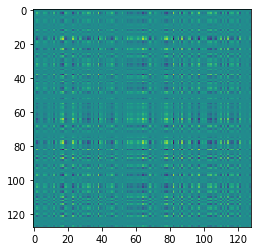

In [0]:
#@title Change the slider to view different protein interactions! { display-mode: "form", run: "auto" }

VISUALIZE_INTERACTION = 3782 #@param {type: "slider", min:0, max:15000, step:1}

print(interaction_dataset['p1'][VISUALIZE_INTERACTION],interaction_dataset['p2'][VISUALIZE_INTERACTION])
print(f"Interaction? {'True' if interaction_dataset['interaction'][VISUALIZE_INTERACTION] else 'False'}")
plt.imshow(interaction_samples[VISUALIZE_INTERACTION])
plt.show()

In [0]:
def build_cnn():
  
  model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", input_shape=(128,128,1)),
          tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
          tf.keras.layers.Dropout(0.25),
          tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.25),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation="relu"),
          tf.keras.layers.Dense(2, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)             

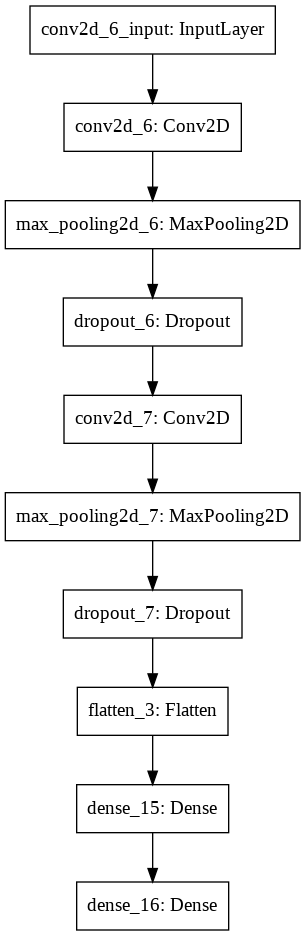

In [0]:
cnn = build_cnn()
print(cnn.summary())
tf.keras.utils.plot_model(cnn)

In [0]:
#from sklearn.model_selection import train_test_split

TEST_SIZE = 0.25
test_size = len(interaction_samples) * TEST_SIZE
SEED = 42

indices = tf.range(start=0, limit=interaction_samples.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

shuffled_x = tf.gather(interaction_samples, shuffled_indices)
shuffled_y = tf.gather(interaction_dataset["interaction"], shuffled_indices)

X_train = shuffled_x[:int(1-test_size),:,:]
X_test = shuffled_x[-int(test_size):,:,:]
y_train = shuffled_y[:int(1-test_size)]
y_test = shuffled_y[-int(test_size):]

#X_train, X_test, y_train, y_test = train_test_split(interaction_samples,interaction_dataset["interaction"], test_size=TEST_SIZE, random_state=SEED)

In [0]:
BATCH_SIZE = 256
EPOCHS = 50

X_train = tf.reshape(X_train, (X_train.shape[0], 128, 128, 1))
history = cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Train on 11251 samples
Epoch 1/50
11251/11251 [==============================] - 3s 243us/sample - loss: 0.4097 - accuracy: 0.8630
Epoch 2/50
11251/11251 [==============================] - 2s 204us/sample - loss: 0.3659 - accuracy: 0.8677
Epoch 3/50
11251/11251 [==============================] - 2s 203us/sample - loss: 0.3603 - accuracy: 0.8677
Epoch 4/50
11251/11251 [==============================] - 2s 202us/sample - loss: 0.3579 - accuracy: 0.8677
Epoch 5/50
11251/11251 [==============================] - 2s 205us/sample - loss: 0.3555 - accuracy: 0.8677
Epoch 6/50
11251/11251 [==============================] - 2s 201us/sample - loss: 0.3595 - accuracy: 0.8677
Epoch 7/50
11251/11251 [==============================] - 2s 202us/sample - loss: 0.3507 - accuracy: 0.8677
Epoch 8/50
11251/11251 [==============================] - 2s 221us/sample - loss: 0.3490 - accuracy: 0.8677
Epoch 9/50
11251/11251 [==============================] - 2s 203us/sample - loss: 0.3388 - accuracy: 0.8677
Epoch

In [0]:
cnn.save(f"{DRIVE_HOME}/cnn.h5")

In [0]:
X_test = tf.reshape(X_test, (X_test.shape[0], 128, 128, 1))
results = cnn.evaluate(X_test, y_test, batch_size=128)
print("Test Loss, Test Accuracy:", results)

3750/3750 [==============================] - 0s 105us/sample - loss: 0.0782 - accuracy: 0.9781
Test Loss, Test Accuracy: [0.07824438007672628, 0.9781333]


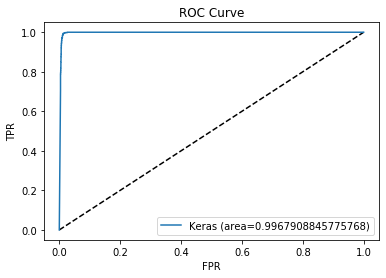

<Figure size 432x288 with 0 Axes>

In [0]:
from sklearn.metrics import roc_curve, auc
y_pred = cnn.predict(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred.squeeze()[:,1])
area_curve = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label=f'Keras (area={area_curve})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

In [0]:
#@title Change the slider to look at the model's predictions! { display-mode: "form", run: "auto" }

PREDICT_INDEX = 6922 #@param {type: "slider", min:0, max:15000, step:1}

p1, p2 = interaction_dataset['p1'][PREDICT_INDEX],interaction_dataset['p2'][PREDICT_INDEX]
print(f"Predict {p1} with {p2}")
print(f"Interaction: {'True' if interaction_dataset['interaction'][PREDICT_INDEX] else 'False'}")
p = tf.reshape(interaction_samples[PREDICT_INDEX], (1,128,128,1))
y = cnn.predict(p)
y = y.squeeze()
print(f"Probability 0: {y[0]}")
print(f"Probability 1: {y[1]}")
print(f"Prediction: {'True' if np.argmax(y) else 'False'}")

Predict 9606.ENSP00000384364 with 9606.ENSP00000290438
Interaction: False
Probability 0: 1.0
Probability 1: 3.484162647282574e-08
Prediction: False


# Testing on Protein Interactions from Other Species

In [6]:
# Saccharmoyces cerevisiae (Yeast)
!wget https://stringdb-static.org/download/protein.links.detailed.v11.0/4932.protein.links.detailed.v11.0.txt.gz
!wget https://stringdb-static.org/download/protein.sequences.v11.0/4932.protein.sequences.v11.0.fa.gz
!wget https://stringdb-static.org/download/protein.info.v11.0/4932.protein.info.v11.0.txt.gz

!mv 4932.protein.links.detailed.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 4932.protein.sequences.v11.0.fa.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 4932.protein.info.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL

# Drosophilia melanogaster (Fruit Fly)
!wget https://stringdb-static.org/download/protein.links.detailed.v11.0/7227.protein.links.detailed.v11.0.txt.gz
!wget https://stringdb-static.org/download/protein.sequences.v11.0/7227.protein.sequences.v11.0.fa.gz
!wget https://stringdb-static.org/download/protein.info.v11.0/7227.protein.info.v11.0.txt.gz

!mv 7227.protein.links.detailed.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 7227.protein.sequences.v11.0.fa.gz /content/drive/My\ Drive/PhD/PPI_DL
!mv 7227.protein.info.v11.0.txt.gz /content/drive/My\ Drive/PhD/PPI_DL


--2020-01-30 17:48:31--  https://stringdb-static.org/download/protein.links.detailed.v11.0/4932.protein.links.detailed.v11.0.txt.gz
Resolving stringdb-static.org (stringdb-static.org)... 104.26.10.133, 104.26.11.133, 2606:4700:20::681a:a85, ...
Connecting to stringdb-static.org (stringdb-static.org)|104.26.10.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17812973 (17M) [application/x-gzip]
Saving to: ‘4932.protein.links.detailed.v11.0.txt.gz’

4932.protein.links. 100%[===================>]  16.99M  10.7MB/s    in 1.6s    

2020-01-30 17:48:33 (10.7 MB/s) - ‘4932.protein.links.detailed.v11.0.txt.gz’ saved [17812973/17812973]

--2020-01-30 17:48:34--  https://stringdb-static.org/download/protein.sequences.v11.0/4932.protein.sequences.v11.0.fa.gz
Resolving stringdb-static.org (stringdb-static.org)... 104.26.10.133, 104.26.11.133, 2606:4700:20::681a:a85, ...
Connecting to stringdb-static.org (stringdb-static.org)|104.26.10.133|:443... connected.
HTTP request

In [0]:
yeast_links = pd.read_csv(f"{DRIVE_HOME}/4932.protein.links.detailed.v11.0.txt.gz",sep=" ",compression="gzip")
yeast_info = pd.read_csv(f"{DRIVE_HOME}/4932.protein.info.v11.0.txt.gz",sep="\t",compression="gzip")
yeast_seqs = pd.DataFrame(read_fasta(f"{DRIVE_HOME}/4932.protein.sequences.v11.0.fa.gz"),columns=['protein_external_id','sequence'])
yeast_proteins = pd.merge(yeast_info,yeast_seqs,on='protein_external_id')
yeast_proteins = yeast_proteins.set_index('protein_external_id')

fly_links = pd.read_csv(f"{DRIVE_HOME}/7227.protein.links.detailed.v11.0.txt.gz",sep=" ",compression="gzip")
fly_info = pd.read_csv(f"{DRIVE_HOME}/7227.protein.info.v11.0.txt.gz",sep="\t",compression="gzip")
fly_seqs = pd.DataFrame(read_fasta(f"{DRIVE_HOME}/7227.protein.sequences.v11.0.fa.gz"),columns=['protein_external_id','sequence'])
fly_proteins = pd.merge(fly_info,fly_seqs,on='protein_external_id')
fly_proteins = fly_proteins.set_index('protein_external_id')

all_proteins = pd.concat([yeast_proteins, fly_proteins])

In [0]:
val_positive_interactions = pd.DataFrame({
    "p1": pd.concat([yeast_links["protein1"], fly_links["protein1"]]),
    "p2": pd.concat([yeast_links["protein2"], fly_links["protein2"]]),
    "interaction": [1] * (len(yeast_links) + len(fly_links))
})

N_POSITIVE = 10000

val_positive_interactions = val_positive_interactions.sample(N_POSITIVE)

N_NEGATIVE = 10000

val_neg_p1 = np.random.choice(yeast_proteins.index, N_NEGATIVE)
val_neg_p2 = np.random.choice(fly_proteins.index, N_NEGATIVE)

val_negative_interactions = pd.DataFrame({
    "p1": val_neg_p1,
    "p2": val_neg_p2,
    "interaction": [0] * N_NEGATIVE
})

val_interaction_dataset = pd.concat((val_positive_interactions, val_negative_interactions),axis=0)

In [0]:
val_interaction_dataset = val_interaction_dataset.merge(all_proteins,left_on='p1',right_on='protein_external_id')
val_interaction_dataset = val_interaction_dataset.drop(['preferred_name','protein_size','annotation'],axis=1)
val_interaction_dataset = val_interaction_dataset.rename(columns={"sequence":"s1"})
val_interaction_dataset = val_interaction_dataset.merge(all_proteins,left_on='p2',right_on='protein_external_id')
val_interaction_dataset = val_interaction_dataset.drop(['preferred_name','protein_size','annotation'],axis=1)
val_interaction_dataset = val_interaction_dataset.rename(columns={"sequence":"s2"})

In [323]:
val_interaction_dataset

,p1,p2,interaction,s1,s2
0,4932.YJR111C,4932.YNL277W,1,MNQILNAQRLIQLSQFHPKLKNIWYLVAAATFSVCNEPQEIPKLYH...,MSHTLKSKTLQELDIEEIKETNPLLKLVQGQRIVQVPELVLESGVV...
1,4932.YPL156C,4932.YNL277W,1,MIADSSVLKKHTAIKRSTRIISLTLVLLGVFSFLLLTWNDSLEFYN...,MSHTLKSKTLQELDIEEIKETNPLLKLVQGQRIVQVPELVLESGVV...
2,4932.YJR111C,4932.YDR354W,1,MNQILNAQRLIQLSQFHPKLKNIWYLVAAATFSVCNEPQEIPKLYH...,MSEATLLSYTKKLLASPPQLSSTDLHDALLVILSLLQKCDTNSDES...
3,4932.YOR232W,4932.YDR354W,1,MRAFSAATVRATTRKSFIPMAPRTPFVTPSFTKNVGSMRRMRFYSD...,MSEATLLSYTKKLLASPPQLSSTDLHDALLVILSLLQKCDTNSDES...
4,4932.YJR111C,7227.FBpp0074226,0,MNQILNAQRLIQLSQFHPKLKNIWYLVAAATFSVCNEPQEIPKLYH...,MLTNCASKTLAAVRANIRAIATSSARASDNLFVHRDTPEDNPNIPF...
...,...,...,...,...,...
19995,4932.YGR137W,7227.FBpp0298275,0,MHLQPVICKLRLHSNSRRLYHILHLSLITINSLSNSTHHLHSKHRW...,MMSKESSLETCELTLPVGQIKGVKRLSLYDDPYFSFEKIPFAKPPL...
19996,4932.YGR179C,7227.FBpp0075939,0,MAADRDNFLQNIENDSINNGQAMDLSPNRSSSESDSSILMNVNDIK...,MRPILALSLAVLATLVVLSSQATSTSPTSSSSTSPTSSSSTSPTSS...
19997,4932.YOL089C,7227.FBpp0289892,0,MENQGGDYSPNGFSNSASNMNAVFNNEITGRSDISNVNHQTGTPRL...,MRTVPILLLICCLGWLHKGQADERKIGAVGPPMKQRSLRHVSSFAN...
19998,4932.YLR079W,7227.FBpp0087023,0,MTPSTPPRSRGTRYLAQPSGNTSSSALMQGQKTPQKPSQNLVPVTP...,MKFFAVLVCFSAVLAIAMASTATTTSTPTTPSSPTTTTYTYTTTPT...


In [0]:
val_ct1 = np.array([encode_CT(seq) for seq in val_interaction_dataset['s1']])
val_ct2 = np.array([encode_CT(seq) for seq in val_interaction_dataset['s2']])

PADDING_LENGTH = 3530

val_enc1 = tf.keras.preprocessing.sequence.pad_sequences(val_ct1,maxlen=PADDING_LENGTH)
val_enc1 = val_enc1.reshape((val_enc1.shape[0],val_enc1.shape[1],1))
val_enc2 = tf.keras.preprocessing.sequence.pad_sequences(val_ct2,maxlen=PADDING_LENGTH)
val_enc2 = val_enc2.reshape((val_enc2.shape[0],val_enc2.shape[1],1))

print("Encoding first protein...")
val_p1_encodings = encoder.predict(val_enc1)
print("Encoding second protein...")
val_p2_encodings = encoder.predict(val_enc2)

val_interaction_samples = []

for pair in zip(val_p1_encodings, val_p2_encodings):
  val_interaction_samples.append(tf.tensordot(pair[0],pair[1],axes=0))

val_interaction_samples = tf.stack(val_interaction_samples)

In [0]:
val_test = tf.reshape(val_interaction_samples, (val_interaction_samples.shape[0], 128, 128, 1))
val_results = cnn.evaluate(val_test, val_interaction_dataset['interaction'], batch_size=128)
print("Test Loss, Test Accuracy:", val_results)

20000/20000 [==============================] - 2s 81us/sample - loss: 8.1121 - accuracy: 0.4967
Test Loss, Test Accuracy: [8.112130057305098, 0.49665]


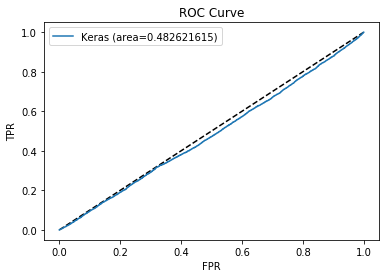

<Figure size 432x288 with 0 Axes>

In [0]:
val_pred = cnn.predict(val_test)
fpr, tpr, thresh = roc_curve(val_interaction_dataset["interaction"], val_pred.squeeze()[:,1])
area_curve = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label=f'Keras (area={area_curve})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

In [0]:
TEST_SIZE = 0.25
test_size = len(val_interaction_samples) * TEST_SIZE
SEED = 42

val_indices = tf.range(start=0, limit=val_interaction_samples.shape[0], dtype=tf.int32)
val_shuffled_indices = tf.random.shuffle(val_indices)

val_shuffled_x = tf.gather(val_interaction_samples, val_shuffled_indices)
val_shuffled_y = tf.gather(val_interaction_dataset["interaction"], val_shuffled_indices)

X_train = val_shuffled_x[:int(1-test_size),:,:]
X_test = val_shuffled_x[-int(test_size):,:,:]
y_train = val_shuffled_y[:int(1-test_size)]
y_test = val_shuffled_y[-int(test_size):]

In [0]:
BATCH_SIZE = 256
EPOCHS = 50

#yeast_fly_cnn = build_cnn()
X_train = tf.reshape(X_train, (X_train.shape[0], 128, 128, 1))
history = yeast_fly_cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=150)

Train on 15001 samples
Epoch 1/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6901 - accuracy: 0.5326
Epoch 2/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6897 - accuracy: 0.5310
Epoch 3/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6895 - accuracy: 0.5298
Epoch 4/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6898 - accuracy: 0.5320
Epoch 5/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6895 - accuracy: 0.5323
Epoch 6/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6893 - accuracy: 0.5332
Epoch 7/150
15001/15001 [==============================] - 3s 197us/sample - loss: 0.6896 - accuracy: 0.5273
Epoch 8/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6890 - accuracy: 0.5366
Epoch 9/150
15001/15001 [==============================] - 3s 198us/sample - loss: 0.6885 - accuracy: 0.5

In [0]:
X_test = tf.reshape(X_test, (X_test.shape[0], 128, 128, 1))
results = yeast_fly_cnn.evaluate(X_test, y_test, batch_size=128)
print("Test Loss, Test Accuracy:", results)

5000/5000 [==============================] - 1s 104us/sample - loss: 0.6884 - accuracy: 0.5362
Test Loss, Test Accuracy: [0.6883846446990967, 0.5362]


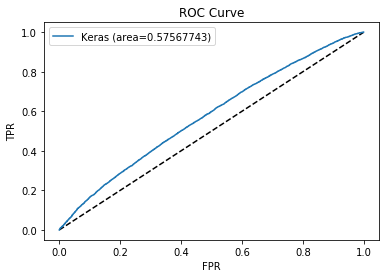

<Figure size 432x288 with 0 Axes>

In [0]:
val_pred = yeast_fly_cnn.predict(val_test)
fpr, tpr, thresh = roc_curve(val_interaction_dataset["interaction"], val_pred.squeeze()[:,1])
area_curve = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label=f'Keras (area={area_curve})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

In [0]:
TRAINING_SIZE = 1000

yeast_fly_autoencode_train = tf.keras.preprocessing.sequence.pad_sequences([encode_CT(s) for s in all_proteins['sequence']])
yeast_fly_autoencode_train = yeast_fly_autoencode_train[:TRAINING_SIZE]
yeast_fly_autoencode_train = yeast_fly_autoencode_train.reshape((yeast_fly_autoencode_train.shape[0], yeast_fly_autoencode_train.shape[1], 1))

In [0]:
val_autoencoder, val_encoder = build_autoencoders(yeast_fly_autoencode_train.shape[1], yeast_fly_autoencode_train.shape[2], 128)

EPOCHS = 5
BATCH_SIZE = 32

val_autoencoder.fit(yeast_fly_autoencode_train, yeast_fly_autoencode_train,epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Train on 1000 samples
Epoch 1/5
  32/1000 [..............................] - ETA: 1:13:16 - loss: 0.2294